# Extraction of tangential interface velocity

The aim is to extract the tangential interface velocity from pseudo 3D (axis-symmetric 2D) VoF simulations. The interface velocity is then used to create a more realistic velocity boundary condition for single phase simulations of rising bubbles, which is necessary to account for the induced shear stress due to the internal motion of the bubble (which otherwise would be missing, e.g., when using a free-slip boundary condition instead). The steps to extract the interface velocity and to create a machine learning model for the boundary are:

* load the PLIC planes and the velocity field
* compute the center of each PLIC plane
* interpolate the velocity vector field to the PLIC center points
* compute the unit normal vector for each PLIC plane
* decompose the velocity vector in tangential and normal contribution (with respect to each plane)
* filter out some data points with bad quality
* train a MLP that takes the polar angle or the arc length as feature and returns the tangential velocity (magnitude) as label

In [1]:
import helper_module as hm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
import torch

# make torch results reproducible and use double precision
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(42)
np.random.seed(42)
model_output = "../output/models/"

data_path = "../data/"
cases = ["wa18_l16", "scap_l16", "dell_l17"]
for i, case in enumerate(cases):
    print(i, data_path + case)
    
# convinience function for saving plots as png and pdf
def savefig(name):
    path = "../output/"
    plt.savefig(path + name + ".png", bbox_inches="tight")
    plt.savefig(path + name + ".pdf", bbox_inches="tight")

0 ../data/wa18_l16
1 ../data/scap_l16
2 ../data/dell_l17


## Load velocity fields, log-files, and PLIC elements

In [2]:
times = [20, 50, 50] # Basilisk simulation time
Ga = [238.287, 134.626, 15.24]
U_b = []

all_fields = {}
all_facets = {}
for i, case in enumerate(cases):
    log_path = data_path + case + "/log." + case + ".csv"
    log = hm.Logfile(log_path)
    log.read_logfile(usecols=['time', 'u_x', 'x'])
    row = log.find_closest("time", times[i])
    U_b.append(row.u_x.values[0])
    field_path = data_path + case + "_vel_t{:2d}.csv".format(times[i])
    all_fields[case] = hm.CenterFieldValues2D(field_path, [0.0, row.x.values[0]], [0.0, row.u_x.values[0]])
    plic_path = data_path + case + "/plic_clean/plic_{:06d}.pkl".format(row.index.values[0]*10)
    all_facets[case] = hm.FacetCollection2D(plic_path, [0, row.x.values[0]], True, all_fields[case])
    print("")

Successfully read file ../data/wa18_l16/log.wa18_l16.csv
Successfully read file ../data/wa18_l16_vel_t20.csv
Successfully read file ../data/wa18_l16/plic_clean/plic_968510.pkl

Successfully read file ../data/scap_l16/log.scap_l16.csv
Successfully read file ../data/scap_l16_vel_t50.csv
Successfully read file ../data/scap_l16/plic_clean/plic_149210.pkl

Successfully read file ../data/dell_l17/log.dell_l17.csv
Successfully read file ../data/dell_l17_vel_t50.csv
Successfully read file ../data/dell_l17/plic_clean/plic_290030.pkl



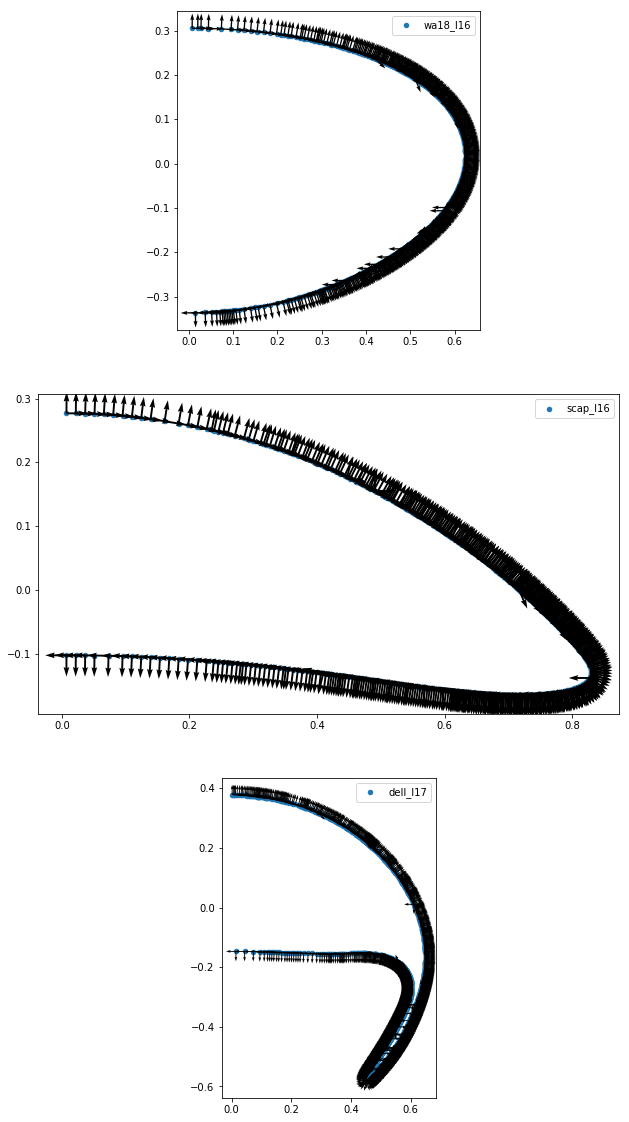

In [3]:
rc('text', usetex=False)
fig, axarr = plt.subplots(3, 1, figsize=(hm.figure_width, 20))

for i, case in enumerate(cases):
    c_x, c_y = all_facets[case].get_facet_centers(polar=False)
    n_vec = all_facets[case].get_unit_normals()
    t_vec = all_facets[case].get_unit_tangentials()
    axarr[i].scatter(c_x, c_y, s=20, label=case)
    axarr[i].quiver(c_x, c_y, n_vec[:, 0], n_vec[:, 1], scale=30, units="xy", width=0.003)
    axarr[i].quiver(c_x, c_y, t_vec[:, 0], t_vec[:, 1], scale=30, units="xy", width=0.003)
    axarr[i].set_aspect("equal")
    axarr[i].legend()

Text(0.5,0,'$\\varphi$')

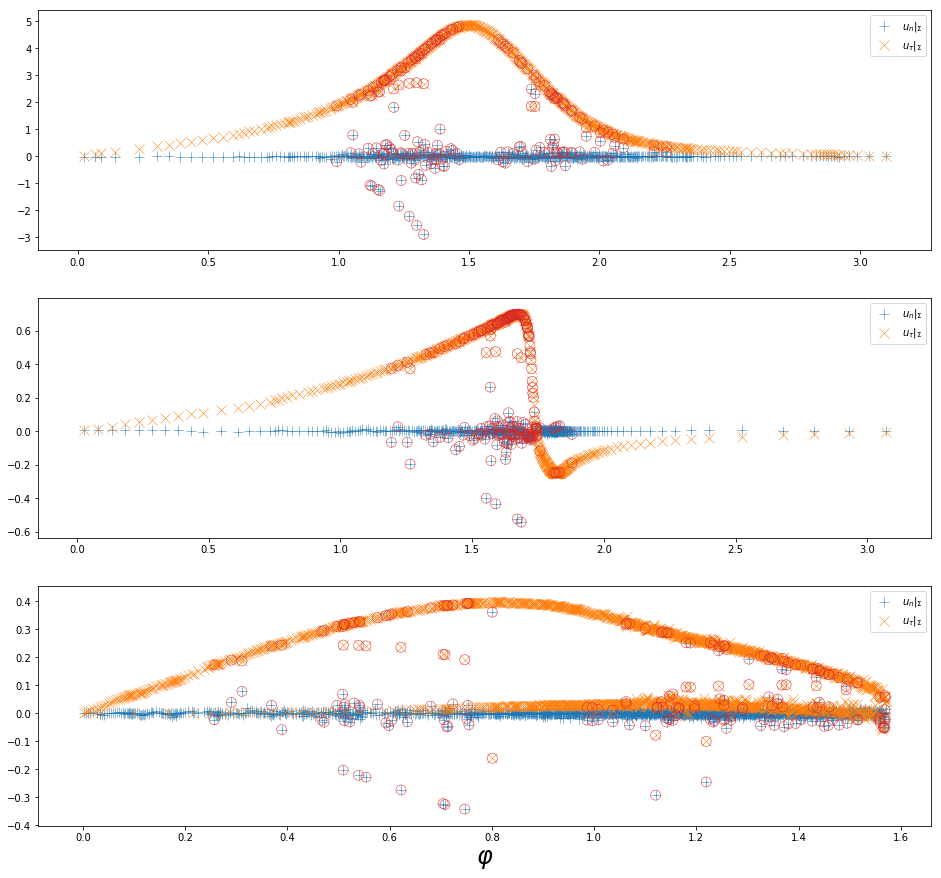

In [4]:
rc('text', usetex=False)
fig, axarr = plt.subplots(3, 1, figsize=(hm.figure_width, 15))

frac = [0.02, 0.02, 0.05]
u_tau_clean = {}
phi_clean = {}
rad_clean = {}

for i, case in enumerate(cases):
    if case == "dell_l17":
        c_x, c_y = all_facets[case].get_facet_centers(polar=False)
        p_x, p_y = all_facets[case].get_facets(polar=False)
        rad, phi = hm.transform_polar_2D(c_x, c_y + abs(np.min(p_y)))
    else:
        rad, phi = all_facets[case].get_facet_centers(polar=True)
    u_n = all_facets[case].project_normal(vector=False)
    u_t = all_facets[case].project_tangential(vector=False)
    tol = frac[i] * np.max(u_t)
    outliers = np.absolute(u_n) < tol
    u_tau_clean[case] = np.asarray([u_t[e] for e in range(u_t.shape[0]) if abs(u_n[e]) < tol])
    phi_clean[case] = np.asarray([phi[e] for e in range(phi.shape[0]) if abs(u_n[e]) < tol])
    rad_clean[case] = np.asarray([rad[e] for e in range(rad.shape[0]) if abs(u_n[e]) < tol])
    axarr[i].scatter(phi, u_n, c="C0", marker="+", s=100, lw=0.5, label=r"$u_{n}|_\Sigma$")
    axarr[i].scatter(phi, u_t, c="C1", marker="x", s=100, lw=0.5, label=r"$u_{\tau}|_\Sigma$")
    axarr[i].scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(u_t, mask=outliers),
                     marker="o", facecolors='none', edgecolors='C3', s=100, lw=0.5)
    axarr[i].scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(u_n, mask=outliers),
                     marker="o", facecolors='none', edgecolors='C3', s=100, lw=0.5)
    axarr[i].legend()
axarr[-1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)

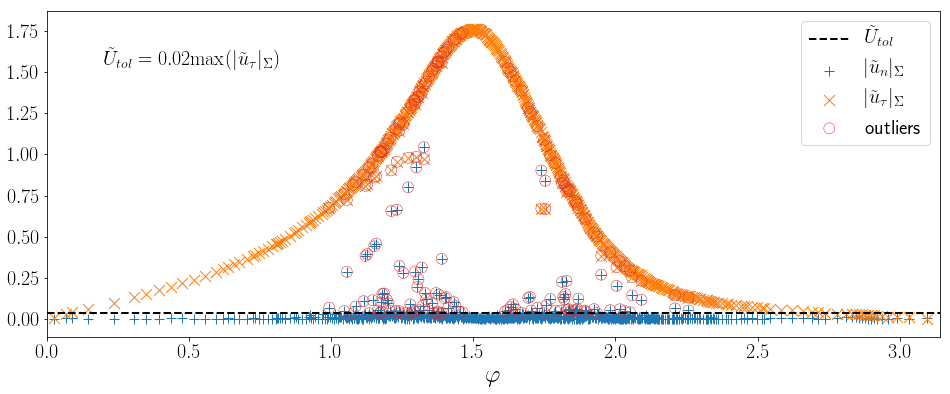

In [5]:
rc('text', usetex=True)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

case_name = "wa18_l16"
rad, phi = all_facets[case_name].get_facet_centers(polar=True)
u_n = np.absolute(all_facets[case_name].project_normal(vector=False)) / U_b[0]
u_t = np.absolute(all_facets[case_name].project_tangential(vector=False)) / U_b[0]
tol = 0.02 * np.max(u_t)
outliers = np.absolute(u_n) < tol
ax.scatter(phi, u_n, c="C0", marker="+", s=120, lw=1.0, label=r"$|\tilde{u}_{n}|_\Sigma$")
ax.scatter(phi, u_t, c="C1", marker="x", s=120, lw=1.0, label=r"$|\tilde{u}_{\tau}|_\Sigma$")
ax.scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(u_t, mask=outliers),
           marker="o", facecolors='none', edgecolors='C3', s=120, lw=0.5)
ax.scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(u_n, mask=outliers),
           marker="o", facecolors='none', edgecolors='C3', s=120, lw=0.5, label=r"outliers")
ax.axhline(tol, 0.0, 1.0, ls="--", lw=2, color="k", label=r"$\tilde{U}_{tol}$")

ax.text(0.2, 1.5, r"$\tilde{U}_{tol} = 0.02\mathrm{max}(|\tilde{u}_\tau|_\Sigma)$",
        horizontalalignment='left', verticalalignment='bottom', fontsize=hm.fontsize_legend)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_xlim(0.0, np.pi)

ax.legend(fontsize=hm.fontsize_legend)
savefig("basilisk_2D_u_sigma_outliers")

## Create models for simple shapes

  1%|          | 26/3000 [00:00<00:11, 257.49it/s]

Minimal loss:  3.94488628951e-06


100%|██████████| 3000/3000 [00:09<00:00, 313.66it/s]


Minimal loss:  1.00340145252e-05


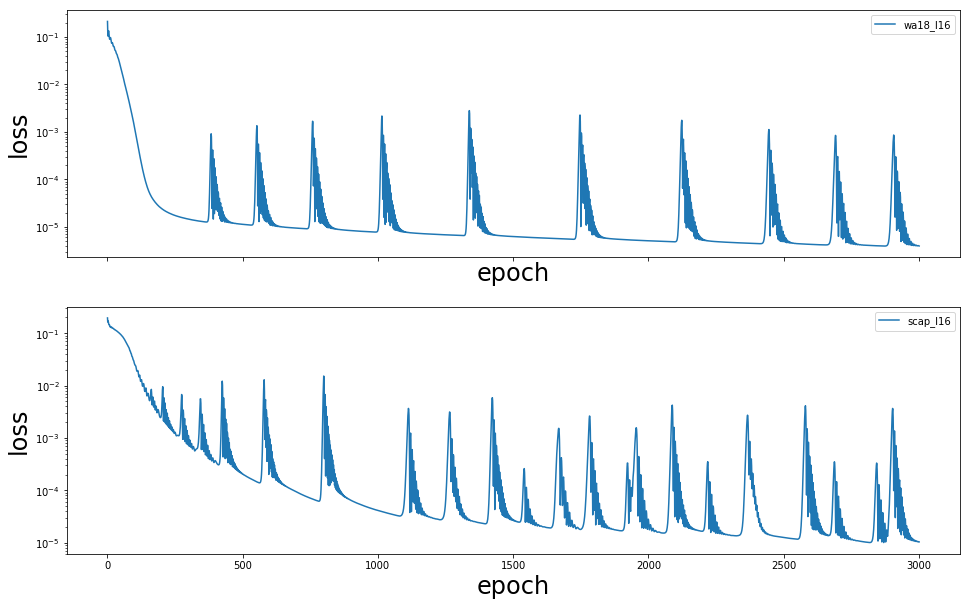

In [6]:
simple_cases = ["wa18_l16", "scap_l16"]

rc('text', usetex=False)
fig, axarr = plt.subplots(2, 1, figsize=(hm.figure_width, 10), sharex=True)

model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 40,
    "activation" : torch.nn.functional.selu,
    "batch_norm" : False
}



epochs = 3000
for i, name in enumerate(simple_cases):
    model = hm.SimpleMLP(**model_dict)
    phi = phi_clean[name]
    phi = np.append(phi, np.asarray([0.0, np.pi]), axis=0)
    u_t = u_tau_clean[name]
    u_t = np.append(u_t, np.asarray([0.0, 0.0]), axis=0)
    weight = np.ones(phi.shape[0])
    weight[-2:] = 4.0
    u_t_norm = (u_t - np.min(u_t)) / (np.max(u_t) - np.min(u_t))
    model_path = model_output + name + "u_t_norm.pt"
    model = hm.SimpleMLP(**model_dict)
    model, losses = hm.training_loop(model, model_path, phi, u_t_norm, weight, epochs, 0.001)
    print("Minimal loss: ", np.min(losses))
    axarr[i].plot(range(1, epochs+1), losses, label=name)
    axarr[i].set_xlabel("epoch", fontsize=hm.fontsize_label)
    axarr[i].set_ylabel("loss", fontsize=hm.fontsize_label)
    axarr[i].set_yscale('log')
    axarr[i].legend()

values at phi = 0 / pi
0.0119234615325  /  0.0268422134494
0.00445577890067  /  -0.00255667301963


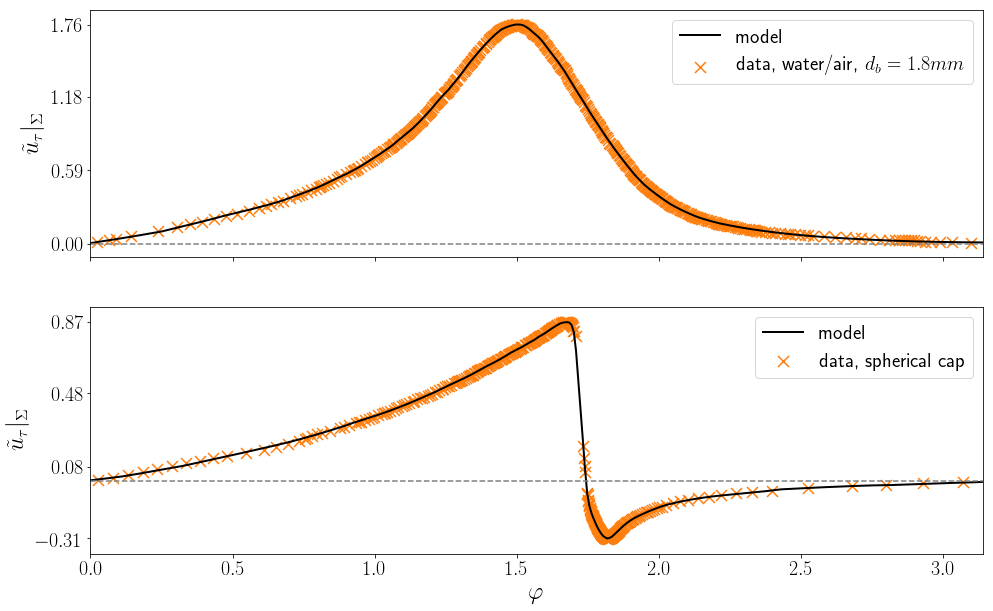

In [7]:
rc('text', usetex=True)
fig, axarr = plt.subplots(2, 1, figsize=(hm.figure_width, 10), sharex=True)
U_b_simple = U_b[:2]
labels = [r"data, water/air, $d_b=1.8mm$", r"data, spherical cap"]

phi_eval = torch.from_numpy(np.linspace(0.0, np.pi, 400)).unsqueeze(-1)
print("values at phi = 0 / pi")
for i, name in enumerate(simple_cases):
    model = hm.SimpleMLP(**model_dict)
    model_path = model_output + name + "u_t_norm.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    u_t = u_tau_clean[name]
    u_model = model.forward(phi_eval).detach().squeeze().numpy()
    u_model = u_model * (np.max(u_t) - np.min(u_t)) + np.min(u_t)
    print(u_model[0], " / ", u_model[-1])
    
    axarr[i].scatter(phi_clean[name], u_tau_clean[name] / U_b_simple[i], c="C1", marker="x", s=120,
                     label=labels[i])
    axarr[i].plot(phi_eval, u_model / U_b_simple[i], c="k", lw=2, label="model")
    
    u_t_max = np.max(u_model / U_b_simple[i])
    u_t_min = np.min(u_model / U_b_simple[i])
    axarr[i].set_yticks(np.around(np.linspace(u_t_min, u_t_max, 4), 2))
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_xlim(0.0, np.pi)
    axarr[i].set_ylabel(r"$\tilde{u}_{\tau}|_\Sigma$", fontsize=hm.fontsize_label)
    axarr[i].legend(fontsize=hm.fontsize_legend)
    axarr[i].axhline(0.0, 0.0, 1.0, ls="--", color="gray")
axarr[-1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
savefig("basilisk_2D_u_t_simple")

## Create models for dimpled ellipsoidal bubble

In [8]:
shape_data = pd.read_csv(data_path + "dell_l17/arc_length.csv")
xs, ys, length = shape_data.values.T

# add points to improve symmetry
Np = 10
length_ext = np.concatenate((-length[2*Np:0:-1], length, 2 * length[-1] - length[:-Np-1:-1]), axis=0)
xs_ext = np.concatenate((-xs[2*Np:0:-1], xs, 2 * xs[-1] - xs[:-Np-1:-1]), axis=0)
ys_ext = np.concatenate(( ys[2*Np:0:-1], ys, 2 * ys[-1] - ys[:-Np-1:-1]), axis=0)

In [9]:
model_dict = {
    "n_inputs" : 2,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 40,
    "activation" : torch.tanh,
    "batch_norm" : False
}

xs_norm = (xs_ext - np.min(xs)) / (np.max(xs) - np.min(xs))
ys_norm = (ys_ext - np.min(ys)) / (np.max(ys) - np.min(ys))
xys = np.vstack((xs_norm, ys_norm)).T
length_norm = (length_ext - np.min(length)) / (np.max(length) - np.min(length))

epochs = 5000
model = hm.SimpleMLP(**model_dict)
model_path = model_output + "_dell_l17_arc_length.pt"
model = hm.SimpleMLP(**model_dict)
model, losses = hm.training_loop(model, model_path, xys, length_norm, None, epochs, 0.001)

100%|██████████| 5000/5000 [00:44<00:00, 113.59it/s]


L2 norm:  7.26831159316e-05
L_max norm:  0.0400895002838


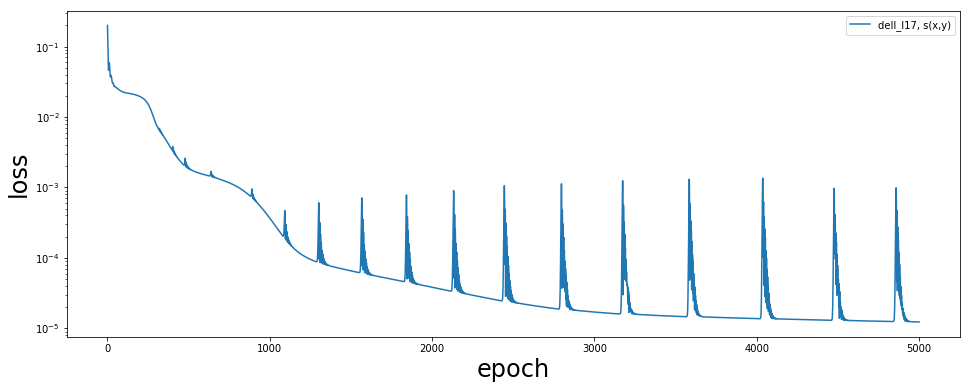

In [10]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

model_path = model_output + "_dell_l17_arc_length.pt"
model.load_state_dict(torch.load(model_path))
model.eval()
s_model = model.forward(torch.from_numpy(xys)).detach().squeeze().numpy()
s_org = s_model * np.max(length)
diff = np.absolute(length_ext - s_org)
print("L2 norm: ", np.mean(np.square(diff)))
print("L_max norm: ", np.max(diff))

ax.plot(range(1, epochs+1), losses, label="dell_l17, s(x,y)")
ax.set_xlabel("epoch", fontsize=hm.fontsize_label)
ax.set_ylabel("loss", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.legend()

Text(0.5,0,'$\\tilde{s}$')

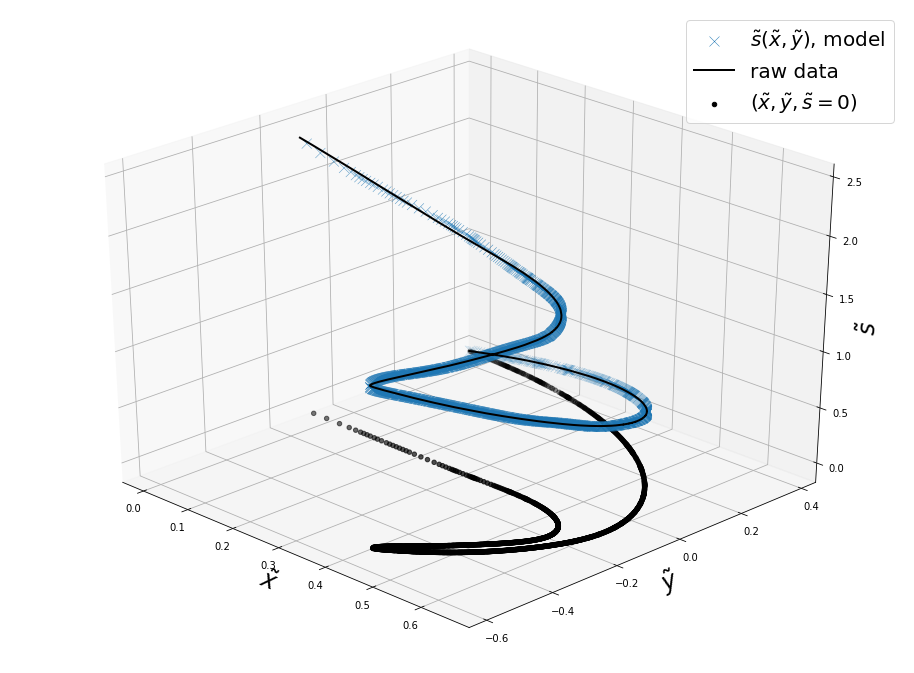

In [11]:
fig = plt.figure(figsize=(hm.figure_width, 12))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')

# predict s based on (x,y) of cleaned data set
model_dict = {
    "n_inputs" : 2,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 40,
    "activation" : torch.tanh,
    "batch_norm" : False
}
model = hm.SimpleMLP(**model_dict)
model_path = model_output + "_dell_l17_arc_length.pt"
model.load_state_dict(torch.load(model_path))
model.eval()
x_cl, y_cl = hm.transform_cartesian_2D(rad_clean["dell_l17"], phi_clean["dell_l17"])
y_cl = y_cl + np.min(ys)
x_cl_norm = x_cl / np.max(xs)
y_cl_norm = (y_cl - np.min(ys)) / (np.max(ys) - np.min(ys))
xy_cl = np.vstack((x_cl_norm, y_cl_norm)).T
s_model = model.forward(torch.from_numpy(xy_cl)).detach().squeeze().numpy()
s_clean = s_model * np.max(length)

line0 = ax1.scatter(x_cl, y_cl, s_clean, lw=0.5, color="C0", marker="x", s=100, label=r"$\tilde{s}(\tilde{x},\tilde{y})$, model")
line1 = ax1.plot(xs, ys, length, ls="-", lw=2, color="k", label="raw data")
line2 = ax1.scatter(x_cl, y_cl, np.zeros(x_cl.shape[0]), color="k", lw=1, label=r"$(\tilde{x}, \tilde{y}, \tilde{s}=0)$")
ax1.view_init(30, -45)
ax1.legend(handles=(line0, line1[0], line2), fontsize=hm.fontsize_legend)
ax1.set_xlabel(r"$\tilde{x}$", fontsize=hm.fontsize_label)
ax1.set_ylabel(r"$\tilde{y}$", fontsize=hm.fontsize_label)
ax1.set_zlabel(r"$\tilde{s}$", fontsize=hm.fontsize_label)

In [12]:
model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 40,
    "activation" : torch.tanh,
    "batch_norm" : False
}

u_tau = u_tau_clean["dell_l17"]
u_tau_norm = (u_tau - np.min(u_tau)) / (np.max(u_tau) - np.min(u_tau))

epochs = 4000
model = hm.SimpleMLP(**model_dict)
model_path = model_output + "_dell_l17_u_t_norm.pt"
model = hm.SimpleMLP(**model_dict)

argsort_s = np.argsort(s_clean)
s_model_sort = s_model[argsort_s]
s_clean_sort = s_clean[argsort_s]
u_tau_sort = u_tau[argsort_s]
u_tau_norm_sort = u_tau_norm[argsort_s]
y_cl_sort = y_cl[argsort_s]

weight = np.ones(u_tau.shape[0])
weight[-2:] = 10.0
weight[:3] = 10.0
weight[np.argmin(y_cl_sort)-5:np.argmin(y_cl_sort)+5] = 5

model, losses = hm.training_loop(model, model_path, s_model_sort, u_tau_norm_sort, weight, epochs, 0.001)

100%|██████████| 4000/4000 [00:20<00:00, 195.33it/s]


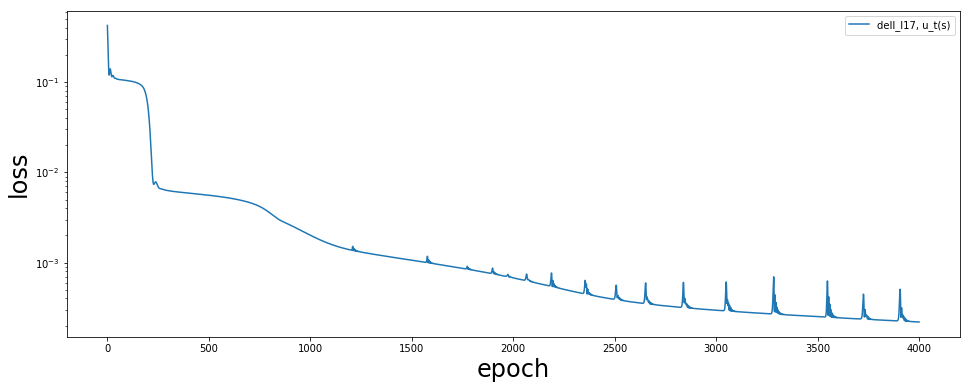

In [13]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

ax.plot(range(1, epochs+1), losses, label="dell_l17, u_t(s)")
ax.set_xlabel("epoch", fontsize=hm.fontsize_label)
ax.set_ylabel("loss", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.legend()

-0.000717353832429 -0.000188659236081


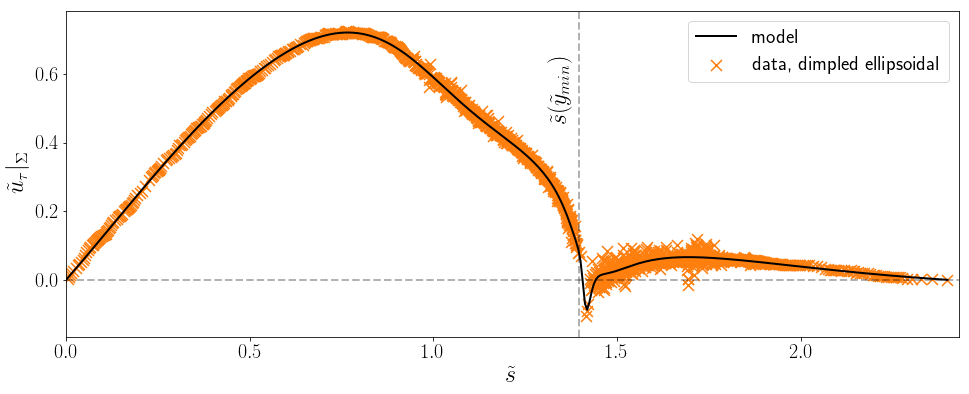

In [14]:
rc('text', usetex=True)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

model_path = model_output + "_dell_l17_u_t_norm.pt"
model.load_state_dict(torch.load(model_path))
model.eval()
s_eval_np = np.linspace(0.0, np.max(s_model), 400)
s_eval = torch.from_numpy(s_eval_np).unsqueeze(-1)
u_tau_model = model.forward(s_eval).detach().squeeze().numpy()
u_tau_org = u_tau_model * (np.max(u_tau) - np.min(u_tau)) + np.min(u_tau)
print(u_tau_org[0], u_tau_org[-1])

ax.scatter(s_clean, u_tau/U_b[2], c="C1", marker="x", s=120, label="data, dimpled ellipsoidal")
ax.plot(s_eval_np*np.max(length), u_tau_org/U_b[2], color="k", lw=2, label="model")
ax.axhline(0.0, 0.0, 1.0, ls="--", lw=2, color="k", alpha=0.3)
ax.axvline(s_clean_sort[np.argmin(y_cl_sort)], 0.0, 1.0, ls="--", lw=2, color="k", alpha=0.3)

ax.tick_params(labelsize=hm.fontsize_tick)
ax.set_xlabel(r"$\tilde{s}$", fontsize=hm.fontsize_label)
ax.set_xlim(0.0, np.max(length))
ax.set_ylabel(r"$\tilde{u}_{\tau}|_\Sigma$", fontsize=hm.fontsize_label)
ax.text(s_clean_sort[np.argmin(y_cl_sort)]-0.08, 0.6, r"$\tilde{s}(\tilde{y}_{min})$",
        rotation=90, fontsize=hm.fontsize_label)

ax.legend(fontsize=hm.fontsize_legend)
savefig("basilisk_2D_u_t_complex")

In [15]:
class FinalVelocityModelSimple(torch.nn.Module):
    def __init__(self, model, u_min, u_max):
        super().__init__()
        self.model = model
        self.u_min = torch.tensor(u_min, dtype=torch.float64)
        self.u_max = torch.tensor(u_max, dtype=torch.float64)
        
    def forward(self, X):
        u = self.model.forward(X)
        u = u * (self.u_max - self.u_min) + self.u_min
        return u.squeeze()

    
class FinalVelocityModelComplex(torch.nn.Module):
    def __init__(self, model_s, X_min, X_max, model_u, u_min, u_max):
        super().__init__()
        self.model_s = model_s
        self.X_max = torch.tensor(X_max, dtype=torch.float64)
        self.X_min = torch.tensor(X_min, dtype=torch.float64)
        self.model_u = model_u
        self.u_min = torch.tensor(u_min, dtype=torch.float64)
        self.u_max = torch.tensor(u_max, dtype=torch.float64)
        
    def forward(self, Xorg):
        X = Xorg.clone()
        X.requires_grad_(False)
        X = (X - self.X_min) / (self.X_max - self.X_min)
        s = self.model_s.forward(X)
        u = self.model_u.forward(s)
        u = u * (self.u_max - self.u_min) + self.u_min
        return u.squeeze()

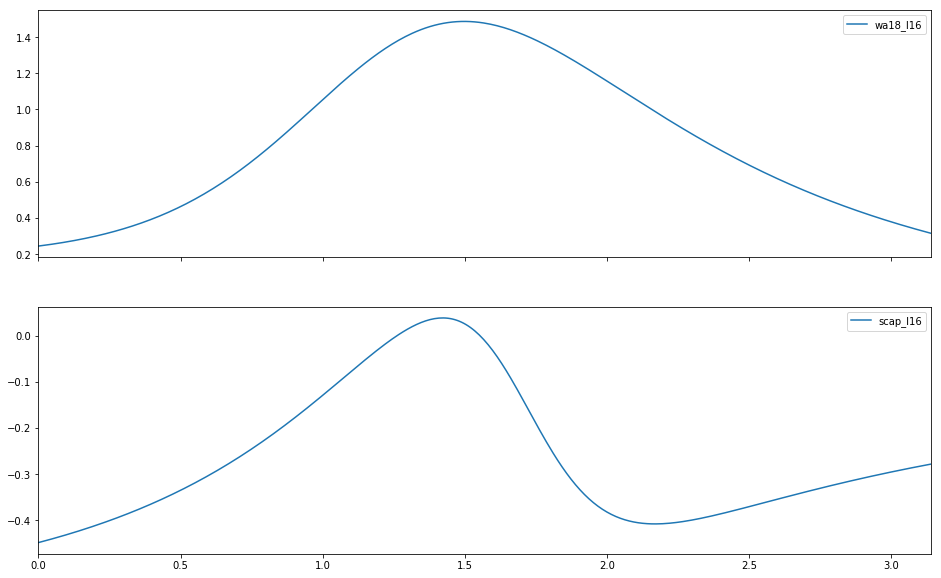

In [16]:
rc('text', usetex=False)
fig, axarr = plt.subplots(2, 1, figsize=(hm.figure_width, 10), sharex=True)

phi_eval = torch.from_numpy(np.linspace(0.0, np.pi, 400)).unsqueeze(-1)

for i, name in enumerate(simple_cases):
    model = hm.SimpleMLP(**model_dict)
    model_path = model_output + name + "u_t_norm.pt"
    model.load_state_dict(torch.load(model_path))
    u_t = u_tau_clean[name]
    full_model = FinalVelocityModelSimple(model, np.min(u_t), np.max(u_t))
    u_model = full_model.forward(phi_eval)
    axarr[i].plot(phi_eval.detach(), u_model.detach(), label=name)
    axarr[i].set_xlim(0.0, np.pi)
    axarr[i].legend()
    # trace and save
    model_trace = torch.jit.trace(full_model, phi_eval[0])
    model_trace.save(model_output + name + "_u_tau_ts.pt")

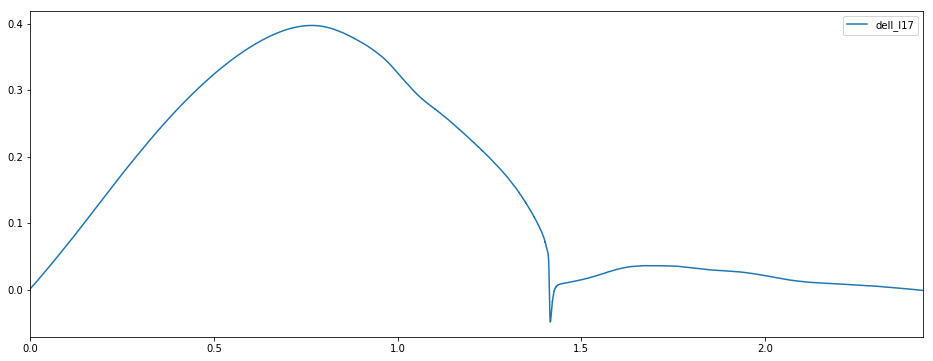

In [17]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6), sharex=True)

xy = np.vstack((xs, ys)).T
xy_scaler = MinMaxScaler()
xy_scaler.fit_transform(xy)

model_dict["n_inputs"] = 2
model_dict["activation"] = torch.tanh
model_s = hm.SimpleMLP(**model_dict)
model_path = model_output + "_dell_l17_arc_length.pt"
model_s.load_state_dict(torch.load(model_path))
model_dict["n_inputs"] = 1
#model_dict["activation"] = torch.nn.functional.selu
model_u = hm.SimpleMLP(**model_dict)
model_path = model_output + "_dell_l17_u_t_norm.pt"
model_u.load_state_dict(torch.load(model_path))
full_model = FinalVelocityModelComplex(model_s, xy_scaler.data_min_, xy_scaler.data_max_,
                                       model_u, np.min(u_tau), np.max(u_tau))
u_model = full_model.forward(torch.from_numpy(xy)).detach().numpy()
ax.plot(length, u_model, label="dell_l17")
ax.set_xlim(0.0, np.max(length))
ax.legend()
# trace and save
model_trace = torch.jit.trace(full_model, torch.from_numpy(xy[0]))
model_trace.save(model_output + "dell_l17_u_tau_ts.pt")